<a href="https://colab.research.google.com/github/shirokamohara/nvm/blob/master/GAN_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import os

import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

In [8]:
file_name = list(uploaded.keys())[0]
data = np.load(file_name)

data = data/255
data = np.reshape (data, (data.shape[0], 28, 28, 1))
img_w, img_h = data.shape[1:3]

NameError: ignored

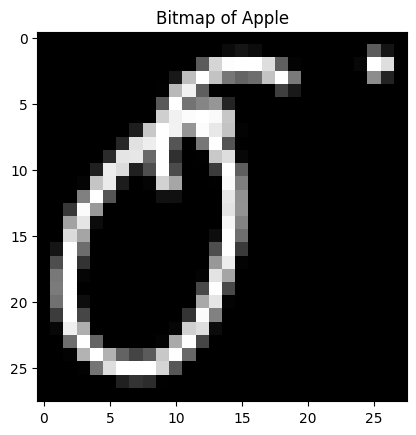

In [13]:
plt.imshow(data[0, :, :, 0], cmap="gray")
plt.title("Bitmap of Apple")
plt.show()

In [6]:
def build_discriminator(depth=64, p=0.4):
  image =Input((img_w, img_h, 1))
  conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
  conv1 = Dropout(p)(conv1)
  conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
  conv2 = Dropout(p)(conv2)
  conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
  conv3 = Dropout(p)(conv3)
  conv4 = Conv2D(depth*8, 5, strides=2, padding='same', activation='relu')(conv3)
  conv4 = Flatten()(Dropout(p)(conv4))
  prediction = Dense(1, activation = "sigmoid")(conv4)
  model = Model(inputs=image, outputs=prediction)
  return model

In [7]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008,clipvalue=1.0), metrics=['accuracy'])

NameError: ignored

In [38]:
z_dimensions =32
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
  noise = Input((latent_dim,))
  dense1 = Dense(7*7*depth)(noise)
  dense1 = BatchNormalization(momentum=0.9)(dense1)
  dense1 = Activation(activation='relu')(dense1)
  dense1 = Reshape((7,7,depth))(dense1)
  dense1 = Dropout(p)(dense1)
  conv1 = UpSampling2D()(dense1)
  conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
  conv1 = BatchNormalization(momentum=0.9)(conv1)
  conv1 = Activation(activation='relu')(conv1)
  conv2 = UpSampling2D()(conv1)
  conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
  conv2 = BatchNormalization(momentum=0.9)(conv2)
  conv2 = Activation(activation='relu')(conv2)
  conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
  conv3 = BatchNormalization(momentum=0.9)(conv3)
  conv3 = Activation(activation='relu')(conv3)
  image = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
  model = Model(inputs=noise, outputs=image)
  return model

In [39]:
generator = build_generator()

In [40]:
z = Input(shape=(z_dimensions,))
img = generator(z)
discriminator.trainable = False
pred = discriminator(img)
adversarial_model = Model(z, pred)

In [41]:
adversarial_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0008,clipvalue=1.0), metrics=['accuracy'])

In [2]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):

  d_metrics = []
  a_metrics = []

  running_d_loss = 0
  running_d_acc = 0
  running_a_loss = 0
  running_a_acc = 0

  for i in range(epochs):
    real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
    fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))

    x = np.concatenate((real_imgs, fake_imgs))

    y = np.ones([2*batch,1])
    y[batch:,:] = 0

    d_metrics.append(discriminator.train_on_batch(x,y))

    running_d_loss += d_metrics[-1][0]
    running_d_acc += d_metrics[-1][1]

    noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
    y = np.ones([batch,1])

    a_metrics.append(adversarial_model.train_on_batch(noise,y))
    running_a_loss = a_metrics[-1][0]
    running_a_acc = a_metrics[-1][1]

    if (i+1)%100 == 0:
      print('Epoch #{}'.format(i))
      log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss / 100, running_d_acc / 100)
      print(log_mesg)
      log_mesg = "%d: [A loss: %f, acc: %f]" % (i, running_a_loss / 100, running_a_acc / 100)
      print(log_mesg)

      noise = np.random.uniform(-1.0, 1.0, size=[16,z_dim])
      gen_imgs = generator.predict(noise)

      plt.figure(figsize=(5,5))

      for k in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, k+1)
        plt.imshow(gen_imgs[k, :, :, 0],cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
  return a_metrics, d_metrics

a_metrics_complete, d_metrics_complete =train()

NameError: ignored